# Lab 1: Warmup

## Environment check

Run the following cell to check that your environment is set up properly.

In [1]:
from fastbook import *

# FIXME: check 'pip' path
pip_path = !which pip
assert 'conda' in pip_path[0], "pip path should include conda"

/usr/local/Caskroom/miniconda/base/envs/sp22/lib/python3.9/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


On the lab computers, this should return `True`:

In [2]:
torch.cuda.is_available()

False

Anyone running locally on macOS CPU will need this code; generally you should be using the lab machines though:

In [5]:
import sys
if sys.platform == "darwin":
    # https://stackoverflow.com/a/64855500/69707
    import os
    os.environ['OMP_NUM_THREADS'] = '1'

## Jupyter Notebooks

Add your code and Markdown cells here. Delete this cell.

## Basic Image Classifier

In [6]:
from fastai.vision.all import *

In [7]:
path = untar_data(URLs.PETS)/'images'

In [8]:
def is_cat(x):
    return x[0].isupper()

dls = ImageDataLoaders.from_name_func(
    path, get_image_files_sorted(path),
    valid_pct=0.2, seed=42,
    label_func=is_cat,
    item_tfms=Resize(224))

In [8]:
learn = cnn_learner(
    dls=dls,
    arch=resnet34,
    metrics=error_rate)
learn.fine_tune(epochs=1)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

In [10]:
get_image_files_sorted(path)[0].name

'Abyssinian_1.jpg'

In [53]:
from ipywidgets import widgets
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [54]:
img = PILImage.create(uploader.data[0])
is_cat, _, probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

IndexError: list index out of range

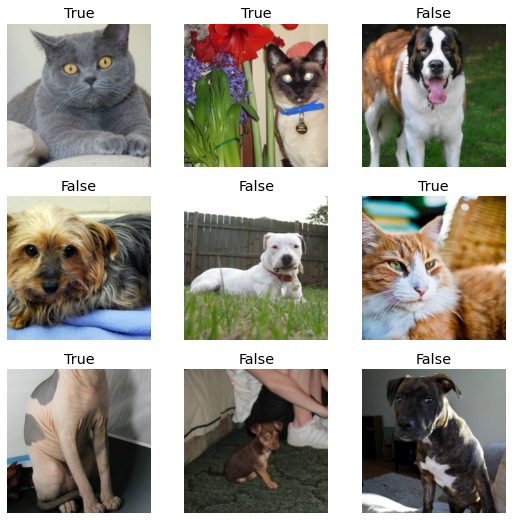

In [9]:
dls.train.show_batch()

## PyTorch

### Broadcasting and Aggregation

In [13]:
y_true = tensor([3.14, 1.59, 2.65])
y_pred = tensor([2.71, 8.28, 1.83])

Compute the residual (error) as true minus predicted. Assign the result to `resid`. **Note: no loop needed!**

Add a line at the end of the cell containing just `resid`. The last expression in any cell gets displayed.

In [14]:
resid = y_true - y_pred
resid

tensor([ 0.4300, -6.6900,  0.8200])

Compute the squared error by raising `resid` to the power 2. (Recall that Python's exponentiation operator is `**`.) Assign this to `squared_error` and display it.

In [15]:
squared_error = resid ** 2
squared_error

tensor([ 0.1849, 44.7561,  0.6724])

Compute the mean of the squared error. Try two different ways: `squared_error.mean()` and `torch.mean(squared_error)`.

In [16]:
squared_error.mean()

tensor(15.2045)

In [18]:
torch.mean(squared_error)

tensor(15.2045)

Now, try to write the entire computation in a single succinct expression

In [ ]:
np.mean((y_true - y_pred) ** 2)

> *Optional aside*: PyTorch tensors also have a `.pow()` method. So you might see `.pow(2)`.

### Dot products

Recall that we can make a line by an expression like `y = w*x + b`. (Some of you may remember *mx+b* , but we'll use *w* for the *weight(s)* instead.)

That's a multiplication followed by a sum. We can extend that to lots of *x*'s, each of which needs a corresponding *w*:

`y = w1*x1 + w2*x2 + ... + wN*xN + b`

For simplicity, let's start by ignoring the `b`ias.  So we're left with

`y = w1*x1 + w2*x2 + ... + wN*xN`

that is, multiply each number in `w` by its corresponding number in `x` and add up the results: `sum(w[i] * x[i] for i in range(N))`.

The result is called a *dot product*, and is one of the fundamental operations in linear algebra. At this point you don't need to understand all the linear algebra part of this, we're just implementing a common calculation.

Let's do that in Python, and then Torch. To start, let's make a `w`eights and an `x`.

In [25]:
w = tensor([-2.0, 1.0])
w

tensor([-2.,  1.])

In [26]:
x = tensor([1.5, 2.0])
x

tensor([1.5000, 2.0000])

The shapes of `w` and `x` must match.

In [29]:
N = len(w)
assert N == len(x)

First, **write a function that uses a `for` loop** to compute the dot product of `w` and `x`. Name the function `dot_loop`. I'll get you started:

In [36]:
def dot_loop(w, x):
    return 0. # FIXME
dot_loop(w, x)

0.0

In [37]:
def dot_loop(w, x):
    result = 0.
    for i in range(N):
        result += w[i] * x[i]
    return result
dot_loop(w, x)

tensor(-1.)

But that's a lot of typing for a concept that we're going to use very frequently. To shorten it (and make it run way faster too!), we'll start taking advantage of some of Torch's builtin functionality.

First, we'll learn about *elementwise operations* (called *pointwise operations* in the [PyTorch docs](https://pytorch.org/docs/stable/torch.html#pointwise-ops)).

If you try to `*` two Python lists together, you get a `TypeError` (how do you multiply lists??). But in PyTorch (and NumPy, which it's heavily based on), array operations happen *element-by-element* (sometimes called *elementwise*): to multiply two tensors that have the same shape, multiply each number in the first tensor with the corresponding number of the second tensor. The result is a new tensor of the same shape with all the elementwise products:

In [39]:
w * x

tensor([-3.,  2.])

Torch also provides [*reduction* methods](https://pytorch.org/docs/stable/torch.html#reduction-ops), so named because they *reduce* the number of elements in a Tensor.
                                          
One really useful reduction op is `.sum`:

In [40]:
w.sum()

tensor(-1.)

(You can also write that as `torch.sum(w)`.)

Now **make a new version of `dot_loop`, called `dot_ops`**, that uses an elementwise op to multiply corresponding numbers and a reduction op to sum the result. Check that the result is the same.

In [ ]:
def dot_ops(w, x):
    return (w * x).sum()

Finally, since `dot` is such an important operation, PyTorch provides it directly:

In [41]:
torch.dot(w, x)

tensor(-1.)

Python recently introduced a "matmul operator", `@`, that does the same thing.

In [42]:
w @ x

tensor(-1.)

## Linear layer

The most basic component of a neural network (and many other machine learning methods) is a *linear transformation layer*. Going back to our `y = w*x + b` example, the `w*x + b` is the linear transformation: given an `x`, dot it with some `w`eights and add a `b`ias.

**Write a function that performs a linear transformation of a vector `x`.** Use PyTorch's built-in functionality for dot products.

## Functions

Write a function that performs the `w*x + b` computation we just did:

In [ ]:
def linear(weights, bias, x):
    return weights @ x + bias
linear(w, 1.0, x)

However, it would be convenient to view the `linear` function as simply a function of `x`, with `weights` and `bias` being internal details. There are several ways to do this; perhaps most familiar to you might be to make a `Linear` class that has these as paramaters. Fill in the blanks here:

In [ ]:
class Linear:
    def __init__(self, weights, bias):
        self.weights = weights
        self.bias = bias
    def forward(self, x):
        return self.weights @ x + self.bias

layer = Linear(w, 1.0)
layer.forward(x)

### Cut below here

But there's another view that you should also get comfortable with: a function can simply return a function.

In [ ]:
def make_multiplier(x):
    def multiply_by(y):
        return x * y
    return multiply_by
make_multiplier(5)(2)

Use this pattern to make a `make_projector`:

In [ ]:
def make_projector(weights, bias):
    def forward(x):
        return weights @ x + bias
    return forward
make_projector(w, 1.0)(x)

*Supplemental Notes (optional)*:

- The inner function is called a *closure*.
- This programming pattern is used quite frequently in user interface programming, e.g,. JavaScript.
- Here we only used it for "partial application"; we could have instead used `functools.partial(f, weights = w, bias = 1.0)`.
- We'll use this later for implementing backpropagation.
